In [1]:
import numpy as np
from easydict import EasyDict
from collections import defaultdict
from sksurv.metrics import concordance_index_ipcw

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from survtrace.dataset import load_data
from pycox.models import DeepHit


In [2]:
np.random.seed(1234)
_ = torch.manual_seed(1234)

In [5]:
df_y_train

,duration,event_0,event_1,proportion
0,3,1.0,0.0,0.365079
1,0,0.0,0.0,0.411765
2,1,1.0,0.0,0.647059
4,2,0.0,0.0,0.958333
8,3,0.0,0.0,0.063492
...,...,...,...,...
476735,3,1.0,0.0,0.206349
476736,3,0.0,0.0,0.825397
476743,3,0.0,0.0,0.317460
476744,3,0.0,0.0,0.317460


In [6]:
df

,Sex,Year of diagnosis,"Race recode (W, B, AI, API)",Histologic Type ICD-O-3,Laterality,Sequence number,ER Status Recode Breast Cancer (1990+),PR Status Recode Breast Cancer (1990+),Summary stage 2000 (1998-2017),RX Summ--Surg Prim Site (1998+),...,CS tumor size (2004-2015),Total number of benign/borderline tumors for patient,Total number of in situ/malignant tumors for patient,duration,event_heart,event_breast,event_0,event_1,duration_disc,proportion
0,0,1,3,1,1,1,2,1,2,9,...,-0.338709,-0.079797,0.941035,81,0.0,1.0,1.0,0.0,3,0.365079
1,0,1,3,0,1,1,1,1,2,9,...,-0.193297,-0.079797,0.941035,7,0.0,0.0,0.0,0.0,0,0.411765
2,0,9,3,5,4,2,0,0,1,0,...,3.441995,-0.079797,2.454367,28,0.0,1.0,1.0,0.0,1,0.647059
3,0,8,3,0,4,1,2,2,1,4,...,-0.334882,-0.079797,2.454367,75,0.0,0.0,0.0,0.0,3,0.269841
4,0,10,3,0,4,1,2,2,1,13,...,-0.308096,-0.079797,0.941035,57,0.0,0.0,0.0,0.0,2,0.958333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476741,0,6,3,7,3,6,0,0,1,0,...,3.441995,-0.079797,-0.572296,96,0.0,0.0,0.0,0.0,3,0.603175
476742,0,6,2,5,1,6,0,0,1,0,...,3.441995,-0.079797,-0.572296,91,0.0,1.0,1.0,0.0,3,0.523810
476743,0,8,2,0,4,6,2,2,1,19,...,-0.315749,-0.079797,-0.572296,78,0.0,0.0,0.0,0.0,3,0.317460
476744,0,8,2,0,1,6,0,0,1,0,...,3.441995,-0.079797,-0.572296,78,0.0,0.0,0.0,0.0,3,0.317460


In [10]:
sum((df['event_0'] == 1) & (df['event_1'] == 1))

0

In [11]:
df_y_train

,duration,event_0,event_1,proportion
0,3,1.0,0.0,0.365079
1,0,0.0,0.0,0.411765
2,1,1.0,0.0,0.647059
4,2,0.0,0.0,0.958333
8,3,0.0,0.0,0.063492
...,...,...,...,...
476735,3,1.0,0.0,0.206349
476736,3,0.0,0.0,0.825397
476743,3,0.0,0.0,0.317460
476744,3,0.0,0.0,0.317460


In [12]:
pc_hazard_config = EasyDict({
    'data': 'seer',
    'horizons': [.25, .5, .75],
    'batch_size': 1024,
    'learning_rate': 0.01,
    'epochs': 100,
    'hidden_size': 32
})
# event_0: Heart Disease
# event_1: Breast Cancer
event_to_censor = 'event_0'

# load data
df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data(pc_hazard_config)

x_train = np.array(df_train, dtype='float32')
x_val = np.array(df_val, dtype='float32')
x_test = np.array(df_test, dtype='float32')

# make event variable
# 0: right censored
# 1: Heart Disease (event_0)
# 2: Breast Cancer (event_1)
def make_event_col(df):
    df['event'] = np.where(df['event_0'] == 1,
                            1,
                            np.where(df['event_1'] == 1,
                                    2,
                                    0
                                    )
                            )
    return df
df = make_event_col(df)
df_y_train = make_event_col(df_y_train)
df_y_val = make_event_col(df_y_val)
df_y_test = make_event_col(df_y_test)

y_df_to_tuple = lambda df: tuple([np.array(df['duration'], dtype='int64'), np.array(df['event'], dtype='int64')])

y_train = y_df_to_tuple(df_y_train)
y_val = y_df_to_tuple(df_y_val)

## Network architecture

Under, we describe two networks that can be for competing risks:

The first, `SimpleMLP`, is a regular MLP which outputs a `[batch_size x num_risks x num_durations]`, e.g., `[64, 2, 10]` tensor.

The other, `CauseSpecificNet` is similar to the cause-specific network described in the [DeepHit paper](http://medianetlab.ee.ucla.edu/papers/AAAI_2018_DeepHit).
It has the same output shape as the `SimpleMLP`, but is a little more complex to make.

In [4]:
class SimpleMLP(torch.nn.Module):
    """Simple network structure for competing risks.
    """
    def __init__(self, in_features, num_nodes, num_risks, out_features, batch_norm=True,
                 dropout=None):
        super().__init__()
        self.num_risks = num_risks
        self.mlp = tt.practical.MLPVanilla(
            in_features, num_nodes, num_risks * out_features,
            batch_norm, dropout,
        )
        
    def forward(self, input):
        out = self.mlp(input)
        return out.view(out.size(0), self.num_risks, -1)

In [5]:
class CauseSpecificNet(torch.nn.Module):
    """Network structure similar to the DeepHit paper, but without the residual
    connections (for simplicity).
    """
    def __init__(self, in_features, num_nodes_shared, num_nodes_indiv, num_risks,
                 out_features, batch_norm=True, dropout=None):
        super().__init__()
        self.shared_net = tt.practical.MLPVanilla(
            in_features, num_nodes_shared[:-1], num_nodes_shared[-1],
            batch_norm, dropout,
        )
        self.risk_nets = torch.nn.ModuleList()
        for _ in range(num_risks):
            net = tt.practical.MLPVanilla(
                num_nodes_shared[-1], num_nodes_indiv, out_features,
                batch_norm, dropout,
            )
            self.risk_nets.append(net)

    def forward(self, input):
        out = self.shared_net(input)
        out = [net(out) for net in self.risk_nets]
        out = torch.stack(out, dim=1)
        return out

In [6]:
in_features = x_train.shape[1]
num_nodes_shared = [64, 64]
num_nodes_indiv = [32]
num_risks = int(y_train[1].max())
out_features = len(pc_hazard_config.duration_index)
batch_norm = True
dropout = 0.1

# net = SimpleMLP(in_features, num_nodes_shared, num_risks, out_features)
net = CauseSpecificNet(in_features, num_nodes_shared, num_nodes_indiv, num_risks,
                       out_features, batch_norm, dropout)

## Training

We fit the net with the [AdamWR](https://arxiv.org/abs/1711.05101) cyclic optimizer with initial learning rate of 0.01, decoupled_weight_decay of 0.01, initial cycle length of 1 epoch, and multiply the learning rate with 0.8 and cycle length with 2 at each new cycle.

The hyperparameters in the DeepHit loss-function, `alpha` and `sigma`, are set to 0.2 and 0.1, respectively. Note that `alpha` here controls the convex combination of the two losses,
$$\text{loss} = \alpha \text{loss}_\text{NLL} + (1 - \alpha) \text{loss}_\text{rank},$$
and therefore has a different interpretation than in the [DeepHit paper](http://medianetlab.ee.ucla.edu/papers/AAAI_2018_DeepHit).

In [17]:
optimizer = tt.optim.AdamWR(lr=0.01, decoupled_weight_decay=0.01,
                            cycle_eta_multiplier=0.8)
model = DeepHit(net, optimizer, alpha=0.2, sigma=0.1,
                duration_index=pc_hazard_config.duration_index)
callbacks = [tt.callbacks.EarlyStoppingCycle(patience=10)]

In [18]:
%%time
log = model.fit(x_train, y_train, pc_hazard_config.batch_size, pc_hazard_config.epochs, callbacks, val_data=tuple([x_val, y_val]))


0:	[5s / 5s],		train_loss: 0.2611,	val_loss: 0.2542
1:	[5s / 10s],		train_loss: 0.2547,	val_loss: 0.3150
2:	[4s / 15s],		train_loss: 0.2520,	val_loss: 0.2525
3:	[5s / 20s],		train_loss: 0.2529,	val_loss: 0.4570
4:	[5s / 25s],		train_loss: 0.2517,	val_loss: 0.3064
5:	[5s / 31s],		train_loss: 0.2507,	val_loss: 0.3021
6:	[5s / 36s],		train_loss: 0.2500,	val_loss: 0.2515
7:	[5s / 42s],		train_loss: 0.2511,	val_loss: 0.2976
8:	[5s / 47s],		train_loss: 0.2511,	val_loss: 0.2625
9:	[5s / 53s],		train_loss: 0.2504,	val_loss: 0.3348
10:	[5s / 58s],		train_loss: 0.2501,	val_loss: 0.2612
11:	[5s / 1m:4s],		train_loss: 0.2495,	val_loss: 0.2552
12:	[5s / 1m:9s],		train_loss: 0.2492,	val_loss: 0.2549
13:	[5s / 1m:15s],		train_loss: 0.2489,	val_loss: 0.2507
14:	[5s / 1m:20s],		train_loss: 0.2489,	val_loss: 0.2505
15:	[5s / 1m:26s],		train_loss: 0.2500,	val_loss: 0.2759
16:	[5s / 1m:31s],		train_loss: 0.2500,	val_loss: 0.3104
17:	[5s / 1m:37s],		train_loss: 0.2499,	val_loss: 0.3857
18:	[5s / 1m:42s],		

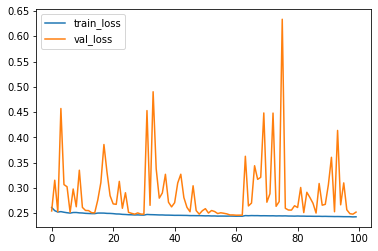

In [19]:
_ = log.plot()

## Evaluation

There is, currently, limited support for competing risks in `pycox`, so the evaluation here is just illustrative and should not be considered *best practice*.

The survival function obtained with `predict_surv_df` is the probability of surviving any of the events, and does, therefore, not distinguish between the event types.
This means that we evaluate this "single-event case" as before.

In [20]:
surv = model.predict_surv_df(x_test)


In [28]:
surv = model.predict_cif(x_test)
surv

array([[[0.01361598, 0.00777657, 0.01040004, ..., 0.10401834,
         0.01338608, 0.01287158],
        [0.04367686, 0.02816727, 0.03104824, ..., 0.1529428 ,
         0.05312771, 0.04463364],
        [0.08943065, 0.05718296, 0.05829053, ..., 0.20079818,
         0.10467018, 0.10786702],
        [0.1091086 , 0.07160877, 0.07025123, ..., 0.22964895,
         0.12653926, 0.21208648],
        [0.42924738, 0.3056506 , 0.7337719 , ..., 0.31935775,
         0.41785908, 0.5010023 ]],

       [[0.00271963, 0.00221334, 0.00439896, ..., 0.05918546,
         0.00127449, 0.00896967],
        [0.00603307, 0.00515503, 0.01029311, ..., 0.0869426 ,
         0.00318429, 0.02187073],
        [0.01078924, 0.01008218, 0.01915548, ..., 0.11640386,
         0.00630479, 0.03909194],
        [0.01316199, 0.01332227, 0.02571438, ..., 0.13744329,
         0.00775496, 0.0873435 ],
        [0.47520134, 0.63538235, 0.21633083, ..., 0.49884623,
         0.48495868, 0.40676814]]], dtype=float32)

In [36]:
class Evaluator:
    def __init__(self, df, train_index):
        '''the input duration_train should be the raw durations (continuous),
        NOT the discrete index of duration.
        '''
        self.df_train_all = df.loc[train_index]

    def eval_multi(self, model, test_set, config, val_batch_size=10000):
        times = config['duration_index'][1:-1]
        horizons = config['horizons']
        df_train_all = self.df_train_all
        get_target = lambda df, risk: (df['duration'].values, df['event_{}'.format(risk)].values)
        df_test, df_y_test = test_set

        metric_dict = defaultdict(list)
        for risk_idx in range(config.num_event):
            durations_train, events_train = get_target(df_train_all, risk_idx)
            durations_test, events_test = get_target(df_y_test, risk_idx)
            print('durations_train', durations_train)

            surv = model.predict_cif(df_test, batch_size=val_batch_size)[risk_idx, :, :]
            risk = 1 - surv
            print('risk', risk)

            et_train = np.array([(events_train[i], durations_train[i]) for i in range(len(events_train))],
                            dtype = [('e', bool), ('t', float)])
            et_test = np.array([(events_test[i], durations_test[i]) for i in range(len(events_test))],
                        dtype = [('e', bool), ('t', float)])
            print('et_test', et_test)


            cis = []
            for i, _ in enumerate(times):
                cis.append(concordance_index_ipcw(et_train, et_test, risk[:, i+1], times[i])[0])            
                metric_dict[f'{horizons[i]}_ipcw_{risk_idx}'] = cis[i]

            for horizon in enumerate(horizons):
                print("Event: {} For {} quantile,".format(risk_idx,horizon[1]))
                print("TD Concordance Index - IPCW:", cis[horizon[0]])
        
        return metric_dict

    

In [37]:
evaluator = Evaluator(df, df_train.index)
evaluator.eval_multi(model, (x_test, df_y_test), config=pc_hazard_config, val_batch_size=10000)

durations_train [81  7 28 ... 78 78 91]
